<a href="https://colab.research.google.com/github/suhanasuffer/MobileV3Net_Model/blob/main/computing_specialization_code_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile, os, shutil
ZIP_PATH = "/content/drive/MyDrive/aibf/Dataset.zip"
WORK_DIR = "/content/aibf_dataset"
if os.path.exists(WORK_DIR):
    shutil.rmtree(WORK_DIR)
os.makedirs(WORK_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(WORK_DIR)

print("Extracted to:", WORK_DIR)
print("Folder listing:", os.listdir(WORK_DIR))

Extracted to: /content/aibf_dataset
Folder listing: ['Dataset']


In [ ]:
!apt-get install -qq -y tesseract-ocr libtesseract-dev
!pip install -q pytesseract

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.6.0-1ubuntu1.5_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.6.0-1ubuntu1.5) ...
Selecting previously unselected package libleptonica-dev.
Preparing to unpack .../libleptonica-dev_1.82.0-3build1_amd64.deb ...
Unpacking libleptonica-dev (1.82.0-3build1) ...
Selecting previously unselected package libtesseract-dev:amd64.
Preparing to unpack .../libtesseract-dev_4.1.1-2.1build1_amd64.deb ...
Unpacking libtesseract-dev:amd64 (4.1.1-2.1build1) ...
Setting up libleptonica-dev (1.82.0-3build1) ...
Setting up libarchive-dev:amd64 (3.6.0-1ubuntu1.5) ...
Setting up libtesseract-dev:amd64 (4.1.1-2.1build1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import glob
import random
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import time
import pathlib

In [ ]:
DATA_DIR = '/content/aibf_dataset/Dataset'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123
INITIAL_EPOCHS = 10
FINETUNE_EPOCHS = 15
NUM_CLASSES = len([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print("Detected classes:", NUM_CLASSES)

Detected classes: 7


In [ ]:
class_folders = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print("Class folders (alphabetical):", class_folders)

Class folders (alphabetical): ['Cardiology', 'Dental', 'Dermatalogy', 'Neurology', 'Oncology', 'Ophthalmology', 'Pathology']


In [ ]:
# CLAHE preprocessing function
# ----------------------
def apply_clahe_and_rescale(img):
    """
    Input: numpy array image (H,W,3), dtype uint8 or float32 in [0,255]
    Output: float32 normalized image in [0,1]
    """
    # ensure uint8
    if img.dtype != np.uint8:
        img_uint8 = (np.clip(img, 0, 255)).astype(np.uint8)
    else:
        img_uint8 = img

    # convert RGB -> LAB
    lab = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    rgb = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    # float32 and scale
    out = (rgb.astype(np.float32) / 127.5) - 1.0
    return out

# quick test of CLAHE
# pick a random image if exists
some_img_files = []
for c in class_folders:
    p = glob.glob(os.path.join(DATA_DIR, c, "*"))
    if len(p) > 0:
        some_img_files.append(p[0])
if some_img_files:
    import imageio
    im = imageio.imread(some_img_files[0])
    im2 = apply_clahe_and_rescale(im)
    print("CLAHE OK:", im.shape, im2.shape, im2.dtype, im2.max())


CLAHE OK: (897, 976, 3) (897, 976, 3) float32 1.0


/tmp/ipython-input-3059034747.py:36: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(some_img_files[0])


In [ ]:
# ImageDataGenerator + Train/Validation Generators
# -----------------------
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=0.12,
    zoom_range=0.12,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=apply_clahe_and_rescale
)

val_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=apply_clahe_and_rescale
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

# confirm mapping
class_indices = train_generator.class_indices
indices_to_class = {v: k for k, v in class_indices.items()}
print("class_indices:", class_indices)
print("indices_to_class:", indices_to_class)

Found 2468 images belonging to 7 classes.
Found 614 images belonging to 7 classes.
class_indices: {'Cardiology': 0, 'Dental': 1, 'Dermatalogy': 2, 'Neurology': 3, 'Oncology': 4, 'Ophthalmology': 5, 'Pathology': 6}
indices_to_class: {0: 'Cardiology', 1: 'Dental', 2: 'Dermatalogy', 3: 'Neurology', 4: 'Oncology', 5: 'Ophthalmology', 6: 'Pathology'}


In [ ]:
# Build MobileNetV3Small model
# -----------------------
tf.keras.backend.clear_session()
base_model = MobileNetV3Small(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 943,159 (3.60 MB)

 Trainable params: 4,039 (15.78 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
# Calculate class weights
# -----------------------
# Count images per class in train generator directory listing
counts = {}
for cls_name in class_folders:
    cls_path = os.path.join(DATA_DIR, cls_name)
    counts[cls_name] = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
print("Image counts per class:", counts)

total_samples = sum(counts.values())
class_weights = {}
# mapping of label index to class name
for idx, cls_name in indices_to_class.items():
    cnt = counts.get(cls_name, 1)
    class_weights[idx] = (total_samples / (NUM_CLASSES * cnt))
print("Class weights:", class_weights)


Image counts per class: {'Cardiology': 192, 'Dental': 514, 'Dermatalogy': 486, 'Neurology': 508, 'Oncology': 500, 'Ophthalmology': 455, 'Pathology': 426}
Class weights: {0: 2.2924107142857144, 1: 0.8563090605892162, 2: 0.9056437389770723, 3: 0.8664229471316085, 4: 0.8802857142857143, 5: 0.9673469387755103, 6: 1.0331991951710262}


In [ ]:
# Initial Training (feature extraction)
# -----------------------
history1 = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.1516 - loss: 1.9923 - val_accuracy: 0.2313 - val_loss: 1.8798
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.2354 - loss: 1.8872 - val_accuracy: 0.4137 - val_loss: 1.8273
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.2696 - loss: 1.8176 - val_accuracy: 0.5293 - val_loss: 1.7453
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3395 - loss: 1.7482 - val_accuracy: 0.4870 - val_loss: 1.7031
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.3903 - loss: 1.6829 - val_accuracy: 0.5244 - val_loss: 1.6473
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.4536 - loss: 1.6310 - val_accuracy: 0.6873 - val_loss: 1.5793
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.5022 - loss: 1.5780 - val_accuracy: 0.6319 - val_loss: 1.5292
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5351 - loss: 1.5294 - val_accuracy: 0.6580 - val_l

In [ ]:
# -----------------------
# Fine-tuning - unfreeze some layers
# -----------------------
for layer in base_model.layers[-80:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)


history2 = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS + FINETUNE_EPOCHS + 10,
    validation_data=val_generator,
    initial_epoch=history1.epoch[-1] + 1,
    class_weight=class_weights
)

Epoch 11/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.4619 - loss: 2.0760 - val_accuracy: 0.2508 - val_loss: 1.6770
Epoch 12/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9694 - loss: 0.1608 - val_accuracy: 0.2590 - val_loss: 1.7058
Epoch 13/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9869 - loss: 0.0611 - val_accuracy: 0.2785 - val_loss: 1.7121
Epoch 14/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9909 - loss: 0.0446 - val_accuracy: 0.2671 - val_loss: 1.7248
Epoch 15/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9934 - loss: 0.0279 - val_accuracy: 0.2524 - val_loss: 1.7425
Epoch 16/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9917 - loss: 0.0340 - val_accuracy: 0.2362 - val_loss: 1.7853
Epoch 17/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9965 - loss: 0.0163 - val_accuracy: 0.2410 - val_loss: 1.7955
Epoch 18/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9960 - loss: 0.0147 - val_accuracy: 0.

In [ ]:
class_indices = train_generator.class_indices
print(class_indices)

{'Cardiology': 0, 'Dental': 1, 'Dermatalogy': 2, 'Neurology': 3, 'Oncology': 4, 'Ophthalmology': 5, 'Pathology': 6}


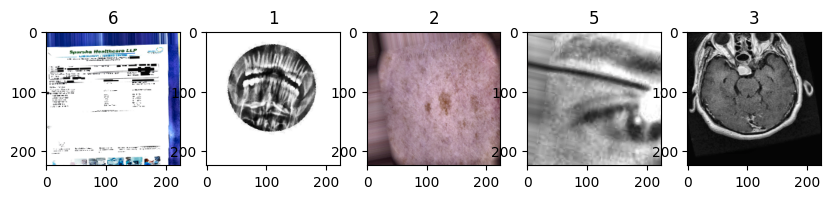

In [ ]:
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow((x_batch[i]+1)/2)  # convert [-1,1] back to [0,1] for display
    plt.title(np.argmax(y_batch[i]))
plt.show()


In [ ]:
# Save Keras model
# -----------------------
"""
SAVED_MODEL_DIR = "/content/medical_mobilenetv3_saved"
if os.path.exists(SAVED_MODEL_DIR):
    shutil.rmtree(SAVED_MODEL_DIR)
model.save(SAVED_MODEL_DIR, include_optimizer=False)
print("Saved Keras model to:", SAVED_MODEL_DIR)
"""

'\nSAVED_MODEL_DIR = "/content/medical_mobilenetv3_saved"\nif os.path.exists(SAVED_MODEL_DIR):\n    shutil.rmtree(SAVED_MODEL_DIR)\nmodel.save(SAVED_MODEL_DIR, include_optimizer=False)\nprint("Saved Keras model to:", SAVED_MODEL_DIR)\n'

Found 614 images belonging to 7 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 864ms/step
Classification report:
               precision    recall  f1-score   support

   Cardiology       1.00      1.00      1.00        38
       Dental       1.00      1.00      1.00       102
  Dermatalogy       0.94      1.00      0.97        97
    Neurology       1.00      1.00      1.00       101
     Oncology       1.00      0.95      0.97       100
Ophthalmology       1.00      1.00      1.00        91
    Pathology       1.00      0.99      0.99        85

     accuracy                           0.99       614
    macro avg       0.99      0.99      0.99       614
 weighted avg       0.99      0.99      0.99       614



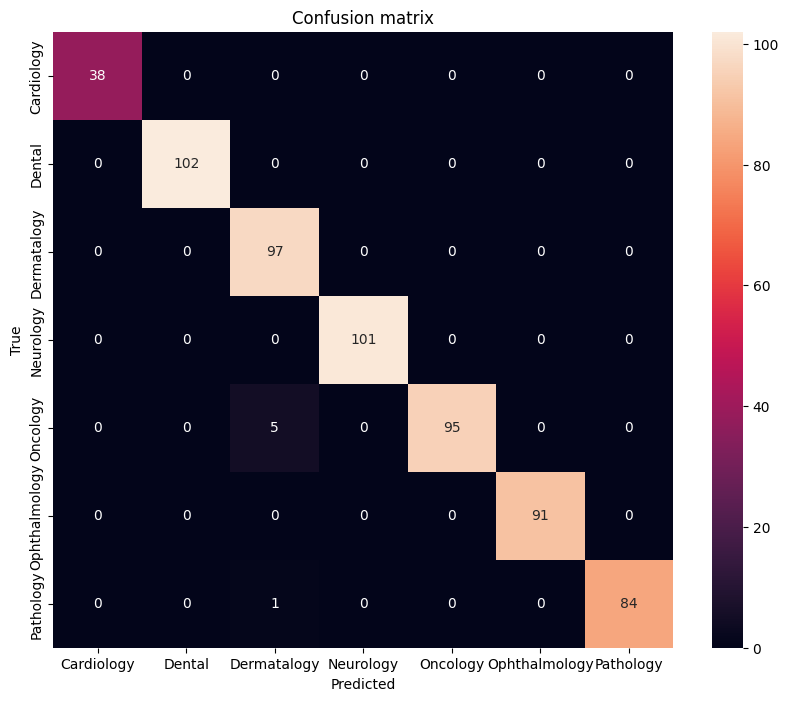

In [ ]:
#  Evaluation - Confusion Matrix & Classification Report
# -----------------------
# build evaluation generator
eval_datagen = ImageDataGenerator(preprocessing_function=apply_clahe_and_rescale, validation_split=0.2)
eval_generator = eval_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

steps = int(np.ceil(eval_generator.samples / BATCH_SIZE))
preds = model.predict(eval_generator, steps=steps)
y_pred = np.argmax(preds, axis=1)
y_true = eval_generator.classes
labels = list(eval_generator.class_indices.keys())

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(10,8))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title("Confusion matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

In [ ]:
model.export("/content/medical_mobilenetv3_3_saved")

Saved artifact at '/content/medical_mobilenetv3_3_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  134704446896464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134703815051408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134703815050256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134704446897808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134703815051984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134703815049488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134703815049296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134704017060688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134703815051216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134703815050064: TensorSpec(shape=(), dtype=tf.resource, name=No

In [ ]:
#  Convert to TFLite (float16 quantization)
# -----------------------
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model("/content/medical_mobilenetv3_3_saved")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

TFLITE_PATH = "/content/medical_mobilenetv3_float16.tflite"
with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)
print("TFLite model saved to:", TFLITE_PATH)
print("TFLite size (MB):", os.path.getsize(TFLITE_PATH) / (1024*1024))

TFLite model saved to: /content/medical_mobilenetv3_float16.tflite
TFLite size (MB): 1.8158378601074219


In [ ]:
#Test TFLite inference on a few validation images
# -----------------------
import tensorflow as tf
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input details:", input_details)
print("Output details:", output_details)

from tensorflow.keras.preprocessing import image

def preprocess_for_inference(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    arr = image.img_to_array(img)  # uint8
    arr = apply_clahe_and_rescale(arr)  # float32 in [0,1]
    return np.expand_dims(arr, axis=0).astype(np.float32)

# pick some sample validation images and run inference
sample_paths = eval_generator.filepaths[:8]  # first few validation files
for p in sample_paths[:8]:
    inp = preprocess_for_inference(p)
    # handle if interpreter input expects float32
    if input_details[0]['dtype'] == np.float32:
        interpreter.set_tensor(input_details[0]['index'], inp.astype(np.float32))
    else:
        # if uint8, we would convert appropriately
        interpreter.set_tensor(input_details[0]['index'], (inp * 255).astype(np.uint8))
    interpreter.invoke()
    out = interpreter.get_tensor(output_details[0]['index'])
    pred_idx = int(np.argmax(out[0]))
    print(os.path.basename(p), "->", indices_to_class[pred_idx])


Input details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 327, 'shape': array([1, 7], dtype=int32), 'shape_signature': array([-1,  7], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
1.jpg -> Cardiology
10.jpg -> Cardiology
100.jpg -> Cardiology
101.jpg -> Cardiology
102.jpg -> Cardiology
103.jpg -> Cardiology
104.jpg -> Cardiology
105.jpg -> Cardiology


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
sample_paths = []
for cls in class_folders:
    files = glob.glob(os.path.join(DATA_DIR, cls, "*"))
    if files:
        sample_paths.append(files[0])

for p in sample_paths:
    inp = preprocess_for_inference(p)
    interpreter.set_tensor(input_details[0]['index'], inp.astype(np.float32))
    interpreter.invoke()
    out = interpreter.get_tensor(output_details[0]['index'])
    pred_idx = int(np.argmax(out[0]))
    print(os.path.basename(p), "->", indices_to_class[pred_idx])


117.jpg -> Cardiology
347.jpg -> Dental
347.jpg -> Dermatalogy
347.jpg -> Neurology
347.jpg -> Oncology
35.png -> Ophthalmology
35.png -> Pathology


In [ ]:
# Save artifacts for app teammate
# -----------------------
# Save the labels mapping to a JSON so the mobile app knows class indexes -> names
import json
LABELS_PATH = "/content/labels_map.json"
with open(LABELS_PATH, "w") as f:
    json.dump(indices_to_class, f)
print("Saved labels mapping to:", LABELS_PATH)

# Provide a smaller sample tflite path and saved model path to give to app developer
print("Artifacts created:")
print(" - TFLite model:", TFLITE_PATH)
print(" - Keras SavedModel:", SAVED_MODEL_DIR)
print(" - labels map:", LABELS_PATH)

Saved labels mapping to: /content/labels_map.json
Artifacts created:
 - TFLite model: /content/medical_mobilenetv3_float16.tflite
 - Keras SavedModel: /content/medical_mobilenetv3_saved
 - labels map: /content/labels_map.json
